In [25]:
def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux'):
    #assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zeta
    gnodes_x = np.linspace(x_min, x_max, n_elem+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_2 = e + 1            # right
        gnode_id_1 = gnode_id_2 - 1   # left
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        # Local node id:  0   1
        patches.append((x1, x2))
        # Local node id:                        0           1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

def get_parent_mapping():
    # zeta in [-1,1]
    parent_mapping = lambda zeta, x_e_bar, h_e: x_e_bar + h_e/2*zeta # compute x
    parent_mapping_prime = lambda h_e: h_e/2                         # compute mapping derivative wrt zeta
    # x in Omega_e
    inverse_parent_mapping = lambda x, x_e_bar, h_e: (x - x_e_bar)*2/h_e # compute zeta
    return (parent_mapping, parent_mapping_prime, inverse_parent_mapping)

def get_parent_basis_functions():
    parent_basis_func_list = list()
    parent_basis_func_prime_list = list()
    parent_basis_func_list.append(lambda zeta: -(zeta-1)/2)  # left
    parent_basis_func_list.append(lambda zeta:  (zeta+1)/2)  # right
    parent_basis_func_prime_list.append(lambda zeta: -1/2) # left
    parent_basis_func_prime_list.append(lambda zeta:  1/2) # right
    
    return (parent_basis_func_list, parent_basis_func_prime_list)

def global_basis_function(i, x, domain_partition, parent_mapping, parent_basis_functions):
    """Evaluate the ith global FE basis function and its derivative on x points.
    
    This is never needed in practice. It is here for demonstrating the theory.
    """
    try:
        len(x)
    except TypeError:
        x = np.array([x])
  
    if not isinstance(x, np.ndarray):
       assert isinstance(x, list) or isinstance(x, tuple)
       x = np.array(x)
  
    phi_i_x = np.copy(x) * 0.0 # initialization
    phi_prime_i_x = np.copy(x) * 0.0 # initialization
        
    patches = domain_partition[0]
    local_to_global_node_id_map = domain_partition[2]
    inverse_parent_mapping = parent_mapping[2]
    parent_basis_func_list = parent_basis_functions[0]
  
    # expensive reverse lookup
    for j, x_j in enumerate(x):
        for e, nodes_x in enumerate(patches):
            if nodes_x[0] <= x_j <= nodes_x[1]:
                n_lnodes = len(nodes_x)
                for I in range(n_lnodes):
                    if local_to_global_node_id_map[e][I] == i:
                        x_e_bar = (nodes_x[0] + nodes_x[1])/2
                        h_e = nodes_x[1] - nodes_x[0]
                        zetta = inverse_parent_mapping(x_j, x_e_bar, h_e)
                        phi_i_x[j] = parent_basis_func_list[I](zetta)
                break
    return phi_i_x

def get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function):
    
    basis_func_list = list()
    n_gnodes = domain_partition[1].size
    local_to_global_node_id_map = domain_partition[2]
    phi_i = lambda i, x: global_basis_function(i,x, domain_partition, parent_mapping, parent_basis_functions)
  
    visited = [False]*n_gnodes
    for e in range(n_elem):
        for I in range(len(local_to_global_node_id_map[e])):
            gnode_id = local_to_global_node_id_map[e][I]
            if gnode_id >= 0 and not visited[gnode_id]:
                      basis_func_list.append(lambda x, i=gnode_id: phi_i(i,x))
                      visited[gnode_id] = True
  
    assert len(basis_func_list) >= 1, 'There are no basis functions to build.'
    
    return basis_func_list

def plot(title='Lagrange Basis Functions'):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('classic')
    plt.figure(1, figsize=(14, 5))

    npts = 200
    x_pts = np.linspace(x_min, x_max, npts)
    for (i,phi_i) in enumerate(phi_list):
        plt.plot(x_pts, phi_i(x_pts),'-',label=r'$\phi_%i$'%i)

    gnodes_x = domain_partition[1]
    plt.scatter(gnodes_x, np.zeros(gnodes_x.size), color='red', marker='x', s=80, label='nodes')

    plt.title(title, fontsize=20)
    plt.ylabel(r'$\phi_i(x)$', fontsize=18)
    plt.xlabel(r'$x$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

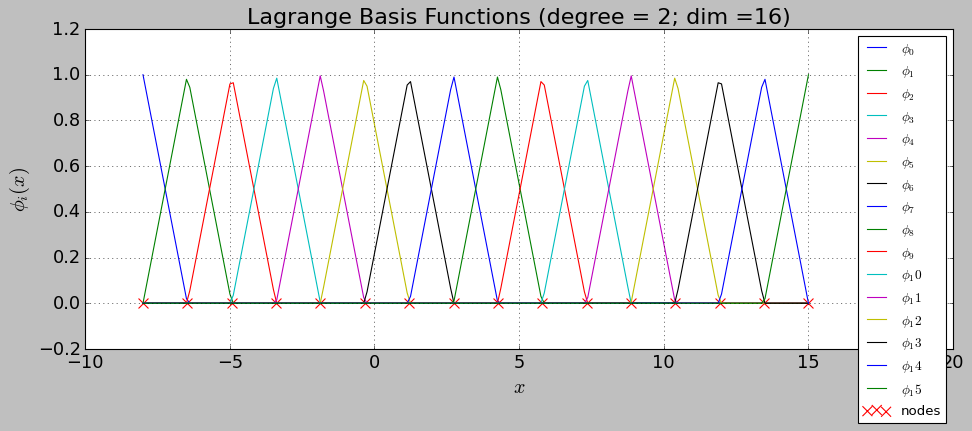

In [26]:
import numpy as np
x_min = -8
x_max = 15

degree = 2
n_elem = 15

# It is implied here the boundary conditions are of type: flux
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)

plot(title=r'Lagrange Basis Functions (degree = %i; dim =%i'%(degree, len(phi_list))+')')

In [17]:
class Shapefns(object):
    """
    Define Quadratic Lagrange shape functions
    These will be defined on the (local) interval [0,1], with
    mid point 0.5
    Shapefns()
    eval(n,xi): phi[n](xi)
    ddx(n,xi): dphi[n](xi)
    size(): number of nodes for these shape functions
    """
    def __init__(self):
        """
        an array of functions for phi and deriv phi
        """
        self.__phi = [lambda xi: 2.0 * (xi-0.5) * (xi-1.0),
                    lambda xi: 4.0 * xi * (1.0-xi),
                    lambda xi: 2.0 * xi * (xi-0.5)]
        # and dphi (derivative of phi w.r.t. xi)
        # derivative of second factor * first + derivative of first factor * second
        self.__dphi = [lambda xi: 2.0 * (xi-0.5) + 2.0*(xi - 1.0),
                    lambda xi: -4.0 * xi + 4.0*(1.0 - xi),
                    lambda xi: 2.0 * xi + 2.0*(xi - 0.5)]
        self.__N = 3  # number of nodes in quadratic Lagrange polynomial
    def eval(self,n,xi):
        """
        the function phi[n](xi), for any xi
        """
        return self.__phi[n](xi)
    def ddx(self,n,xi):
        """
        the function dphi[n](xi), for any xi
        """
        return self.__dphi[n](xi)
    def size(self):
        """
        the number of points
        """
        return self.__N

    def eval(self,n,xi):
        """
        the function phi[n](xi), for any xi
        """
        return self.__phi[n](xi)
    def ddx(self,n,xi):
        """
        the function dphi[n](xi), for any xi
        """
        return self.__dphi[n](xi)
    def size(self):
        """
        the number of points
        """
        return self.__N



FEM1D.py Test case, dx= 1.0
sfns.size()-3= 0


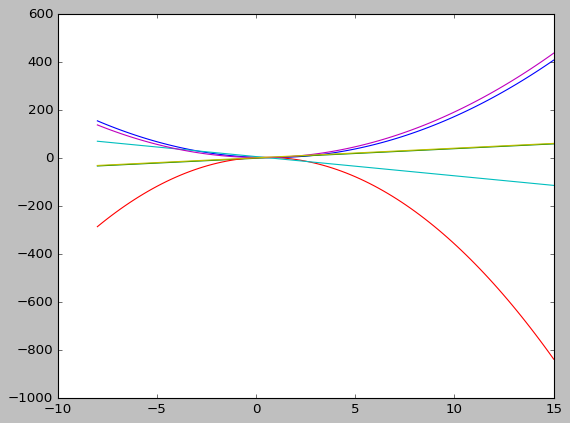

In [21]:
N=5
rightpt = 5.0
print ("\n\nFEM1D.py Test case, dx=",rightpt/N)
# mesh = Mesh(N,0.0,rightpt)
# coords = mesh.coordinates()
# print ("mesh.coordinates()=",coords)
sfns = Shapefns()
print("sfns.size()-3=", sfns.size()-3)
xi = np.linspace(-8,15,100)
import matplotlib.pyplot as plt
if True:
    for n in range(3):
        plt.plot(xi,sfns.eval(n,xi))
        
        plt.plot(xi,sfns.ddx(n,xi))
plt.show()